In [137]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


%matplotlib inline

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
from re import sub
from decimal import Decimal


In [138]:
df = pd.read_csv('../../ML/car-sense-Analytics/car_dataset.csv')


In [139]:
def normalize_segments(raw_segment):
    segments = dict(
        city_values = ['Ciudad'],
        sed_s_values = ['Sedan-SmallSize'],
        sed_m_values = ['Sedan-MidSize', 'Sedan/MidSize/Hybrid'],
        sedan_f_values = ['Sedan-FullSize','Sedan-Fullsize*', 'Sedan-FullSize/Hybrid', 'Sedan-Fullsize'],
        suv_s_values = ['SUV-City', 'SUV-SmallSize'],
        suv_m_values = ['SUV-MidSize'] ,
        suv_f_values = ['SUV-Fullsize', 'SUV-Fullsize/Hybrid', 'SUV-FullSize'],
        suv_xl_values = ['SUV-ExtendedSize','SUV-ExtendedSize/Hybrid'],
        pu_s_values = ['Pickup-SmallSize'],
        pu_m_values = ['Pickup-MidSize'],
        pu_f_values = ['Pickup-FullSize/Hybrid', 'Pickup-FullSize'],
        mini_van_values = ['MiniVan', 'MiniVan/Hybrid']
        
    )
    for k, values in segments.items():
        try:
            if values.index(raw_segment) >= 0:
                return k[:-7]
        except ValueError:
            continue
    
    print('raw_segment: [{}]not found.'.format(raw_segment))
    return 'Not found'
    
df['segment_normalized'] = df['segment'].apply(normalize_segments)

In [140]:
def category_classifer(raw_segment):
    segments = dict(
        city_values = ['Ciudad'],
        sedan_values = [
            'Sedan-SmallSize', 'Sedan-MidSize', 'Sedan/MidSize/Hybrid', 
            'Sedan-FullSize','Sedan-Fullsize*', 'Sedan-FullSize/Hybrid', 'Sedan-Fullsize'
        ],
       
        suv_values = [
            'SUV-City', 'SUV-SmallSize', 'SUV-MidSize', 
            'SUV-Fullsize', 'SUV-Fullsize/Hybrid', 
            'SUV-FullSize','SUV-ExtendedSize', 'SUV-ExtendedSize/Hybrid'
        ],
       
        pu_values = ['Pickup-SmallSize', 'Pickup-MidSize', 'Pickup-FullSize/Hybrid', 'Pickup-FullSize', ],
        mini_van_values = ['MiniVan', 'MiniVan/Hybrid']
        
    )
    for k, values in segments.items():
        try:
            if values.index(raw_segment) >= 0:
                return k[:-7]
        except ValueError:
            continue
    
    print('category: [{}]not found.'.format(raw_segment))
    return 'Not found'

df['category'] = df['segment'].apply(category_classifer)


In [ ]:
def ground_category(raw_segment):
    segments = dict(
        city_values = ['Ciudad'],
        sedan_values = [
            'Sedan-SmallSize', 'Sedan-MidSize', 'Sedan/MidSize/Hybrid', 
            'Sedan-FullSize','Sedan-Fullsize*', 'Sedan-FullSize/Hybrid', 'Sedan-Fullsize'
        ],
       
        suv_values = [
            'SUV-City', 'SUV-SmallSize', 'SUV-MidSize', 
            'SUV-Fullsize', 'SUV-Fullsize/Hybrid', 
            'SUV-FullSize','SUV-ExtendedSize', 'SUV-ExtendedSize/Hybrid'
        ],
       
        pu_values = ['Pickup-SmallSize', 'Pickup-MidSize', 'Pickup-FullSize/Hybrid', 'Pickup-FullSize', ],
        mini_van_values = ['MiniVan', 'MiniVan/Hybrid']
        
    )
    for k, values in segments.items():
        try:
            if values.index(raw_segment) >= 0:
                return k[:-7]
        except ValueError:
            continue
    
    print('category: [{}]not found.'.format(raw_segment))
    return 'Not found'

df['category'] = df['segment'].apply(category_classifer)

In [6]:

main_columns = ['brand', 'model']
filtered_df = df[df['dist_axis'].isna()]

df_groupby = df.groupby(['segment_normalized'])['dist_axis'].mean()




print('dist_axis missing values: {}'.format(df['dist_axis'].isnull().sum()))

def fill_missing_dist_axis(row):
    if np.isnan(row['dist_axis']):
        return df_groupby[row['segment_normalized']]
    else:
        return row['dist_axis']



df['dist_axis'] = df.apply(lambda row: fill_missing_dist_axis(row), axis=1)

print('dist_axis missing values: {}'.format(df['dist_axis'].isnull().sum()))
df['dist_axis'] 

dist_axis missing values: 0
dist_axis missing values: 0


0     2.60
1     2.70
2     2.80
3     2.50
4     2.60
      ... 
87    2.77
88    2.77
89    2.81
90    2.90
91    2.27
Name: dist_axis, Length: 92, dtype: float64

In [141]:
df
# bins = list(range(200000, 2000000, 50000))
# labels_bins = [x for x in bins]


# print(labels_bins)
# df['min_price_bin'] = pd.cut(df['min_price'], bins, labels=labels_bins[:-1])


,brand,model,year,max,min,adult passangers,weight,transmission,fuel,tank,...,cruise_control,cruise_control_advanced,blind_spot_alert,rain_sensor,car_tow,car_pull,body_type,segment,segment_normalized,category
0,Toyota,Yaris,2024,"$388,700","$312,800",5,1035,A/S,Gas,40,...,yes,yes,yes,no,no,no,Sedan,Sedan-SmallSize,sed_s,sedan
1,Toyota,Corolla,2024,"$529,900","$419,900",5,1405,A,Gas,50,...,yes,yes,yes,no,no,no,Sedan,Sedan-MidSize,sed_m,sedan
2,Toyota,Cambry,2024,"$598,800","$571,900",5,1515,A,Gas,60.6,...,yes,yes,yes,no,no,no,Sedan,Sedan-Fullsize*,sedan_f,sedan
3,Toyota,Raize,2024,"$400,000","$378,400",5,1035,A/S,Gas,36,...,no,no,no,no,no,no,SUV,SUV-SmallSize,suv_s,suv
4,Toyota,Corolla Cross,2024,"$528,700","$528,700",5,1425,A,Gas,47,...,yes,yes,yes,no,no,yes,SUV,SUV-MidSize,suv_m,suv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,Kia,Sportage,2024,"$594,900","$752,900",5,1540,A,Gas,54,...,yes,yes,yes,yes,no,no,SUV,SUV-FullSize,suv_f,suv
88,Kia,Sportage Hybrid,2024,"$872,900","$872,900",5,1692,A,Gas/Hybrid,52,...,yes,yes,yes,yes,no,no,SUV,SUV-FullSize,suv_f,suv
89,Kia,Sorento,2024,"$821,900","$985,900",7,1783,A,Gas,67,...,yes,yes,yes,no,yes,yes,SUV,SUV-ExtendedSize,suv_xl,suv
90,Kia,Telluride,2024,"$1,189,900","$1,189,900",7,2036,A,Gas,71,...,yes,yes,yes,no,yes,yes,SUV,SUV-ExtendedSize,suv_xl,suv


## Transformations of data

In [152]:


df['max_price'] = df['max'].apply(lambda x:Decimal(sub(r'[^\d.]', '', x) ))
df['min_price'] = df['min'].apply(lambda x:Decimal(sub(r'[^\d.]', '', x) ))
df['trunk_size_number'] = df['trunk_size'].apply(lambda x:Decimal(sub(r'[^\d.]', '', x) ))
df['transmission_automatic'] = df['transmission'].apply(lambda x: 1 if 'A' in x else 0)

df['weight_number'] = df['weight'].apply(lambda x:Decimal(sub(r'[^\d.]', '', str(x)) ))


cast_boolean = lambda x: 1 if x == 'yes' else 0

# Yes/No Columns
df['cruise_control_advanced'] = df['cruise_control_advanced'].apply(cast_boolean)
df['blind_spot_alert'] = df['blind_spot_alert'].apply(cast_boolean)

df['rain_sensor'] = df['rain_sensor'].apply(cast_boolean)
df['car_tow'] = df['car_tow'].apply(cast_boolean)
df['car_pull'] = df['car_pull'].apply(cast_boolean)
df['rain_sensor'] = df['rain_sensor'].apply(cast_boolean)

In [163]:
# df['height_to_the ground_number'] = df['height_to_the ground']

def cast_height_to_ground(ground):
    value = ground.split('/')[0]
    switcher = {
        'normal': 0,
        'high': 1,
        'extra_high': 2
    }

    return switcher.get(value)

df['ground_clearance'] = df['height_to_the ground'].apply(cast_height_to_ground)


array([0, 1, 2])

In [165]:
# Delete columns not needed
df = df.drop(columns=['body_type', 'segment', 'category', 'max', 'min', 'transmission', 'brand', 'model', 'year', 'weight'] )
df = df.drop(columns=['front_break', 'rear_break', 'braking_assists', 'fuel'] )
df = df.drop(columns=['4x4/awd', 'big_volume_cargo', 'height_to_the ground'] )
df.head()

KeyError: "['body_type', 'segment', 'category', 'max', 'min', 'transmission', 'brand', 'model', 'year', 'weight'] not found in axis"

In [167]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# numeric_columns = ['adult passangers', 'fuel_consumption', 'trunk_size', 'length','min_price']
numeric_columns = ['adult passangers', 'weight_number','fuel_consumption','trunk_size', 'length', 'min_price', 'max_price', 'width', 'height', 'dist_axis', 'ground_clearance']
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])
df.head(10)



ValueError: could not convert string to float: '1,010'

In [31]:
df.columns

Index(['adult passangers', 'fuel', 'fuel_consumption', '4x4/awd',
       'big_volume_cargo', 'trunk_size', 'length', 'width', 'height',
       'dist_axis', 'height_to_the ground', 'front_airbags', 'side_airbags',
       'curtain_air_bags', 'knee_air_bags', 'tire_pressure_monitor', 'NCAP',
       'emergency_brake', 'reverse_camera', 'camera_360', 'bluetooth',
       'android_auto/apple+play', 'cruise_control ', 'cruise_control_advanced',
       'blind_spot_alert', 'rain_sensor', 'car_tow', 'car_pull',
       'segment_normalized', 'min_price', 'transmission_automatic',
       'transmission_manual', 'max_price'],
      dtype='object')

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## SGD Classifier

In [90]:
X = df.drop(columns=[
    'segment_normalized', 'front_airbags', 'side_airbags', 'curtain_air_bags', 'knee_air_bags', 
    'tire_pressure_monitor', 'emergency_brake', 'reverse_camera', 'camera_360', 'bluetooth', 'android_auto/apple+play',
    'cruise_control '
    ])

# X

X.fillna(0, inplace=True)
X


,adult passangers,fuel_consumption,trunk_size,length,width,height,dist_axis,NCAP,cruise_control_advanced,blind_spot_alert,rain_sensor,car_tow,car_pull,min_price,transmission_automatic,transmission_manual,max_price
0,0.500000,0.599604,0.176381,0.285714,0.000000,0.046243,0.150685,5,1,1,0,0,0,0.026306,True,True,0.055910
1,0.500000,0.500496,0.118601,0.380952,0.233766,0.046243,0.196347,5,1,1,0,0,0,0.092133,True,False,0.135014
2,0.500000,0.500496,0.152053,0.476190,0.259740,0.046243,0.242009,5,1,1,0,0,0,0.185556,True,False,0.173613
3,0.500000,0.550050,0.122656,0.095238,0.129870,0.104046,0.105023,5,0,0,0,0,0,0.066626,True,True,0.062241
4,0.500000,0.599604,0.189052,0.285714,0.285714,0.104046,0.150685,5,1,1,0,0,1,0.159004,True,False,0.134342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,0.500000,0.332012,0.189052,0.409524,0.337662,0.121387,0.228311,5,1,1,0,0,0,0.296804,True,False,0.171429
88,0.500000,0.782953,0.279777,0.409524,0.337662,0.121387,0.228311,5,1,1,0,0,0,0.370559,True,False,0.327171
89,0.833333,0.362735,0.279777,0.480952,0.389610,0.130058,0.246575,5,1,1,0,1,1,0.440012,True,False,0.298599
90,0.833333,0.169970,0.279777,0.571429,0.480519,0.150289,0.287671,5,1,1,0,1,1,0.565396,True,False,0.504762


In [91]:
y = df['segment_normalized']

In [92]:


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
	X, y, test_size=0.3, random_state=42)


In [93]:
print('X_train: {0})'.format(X_train))

X_train:     adult passangers  fuel_consumption  trunk_size    length     width  \
31               0.5          0.480674    0.145464  0.350952  0.289610   
77               0.5          0.525273    0.194121  0.442857  0.246753   
9                0.5          0.104063    0.442473  0.761905  0.389610   
70               0.5          0.441031    0.087684  0.128571  0.194805   
5                0.5          0.450942    0.237202  0.380952  0.337662   
..               ...               ...         ...       ...       ...   
20               0.5          0.450942    0.330968  0.380952  0.259740   
60               0.5          0.302279    0.162696  0.390476  0.428571   
71               0.5          0.416254    0.189052  0.314286  0.311688   
14               0.5          0.649158    0.198682  0.333333  0.129870   
51               0.5          0.361744    0.224024  0.309524  0.545455   

      height  dist_axis  NCAP  cruise_control_advanced  blind_spot_alert  \
31  0.092486   0.136986   

In [94]:
print('y_train: {0}'.format(y_train))

y_train: 31      suv_m
77    sedan_f
9        pu_m
70       city
5       suv_f
       ...   
20      suv_f
60      suv_f
71      suv_m
14      sed_m
51      sed_s
Name: segment_normalized, Length: 64, dtype: object


In [95]:
# Create classifier
clf = SGDClassifier(loss='log_loss', alpha=0.01,
                    max_iter=1000, random_state=42,)

In [96]:
# Train the classifier
clf.fit(X_train, y_train)

SGDClassifier(alpha=0.01, loss='log_loss', random_state=42)

In [104]:
# Make predictions
y_pred = clf.predict(X_test)
y_pred

array(['sed_s', 'suv_m', 'suv_m', 'suv_s', 'suv_m', 'suv_s', 'suv_xl',
       'suv_xl', 'suv_s', 'suv_s', 'suv_s', 'suv_xl', 'suv_m', 'suv_xl',
       'suv_m', 'suv_m', 'suv_m', 'suv_s', 'sed_s', 'suv_m', 'suv_m',
       'suv_xl', 'pu_m', 'suv_s', 'suv_m', 'suv_m', 'pu_m', 'suv_m'],
      dtype='<U8')

In [99]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')


Accuracy: 0.25


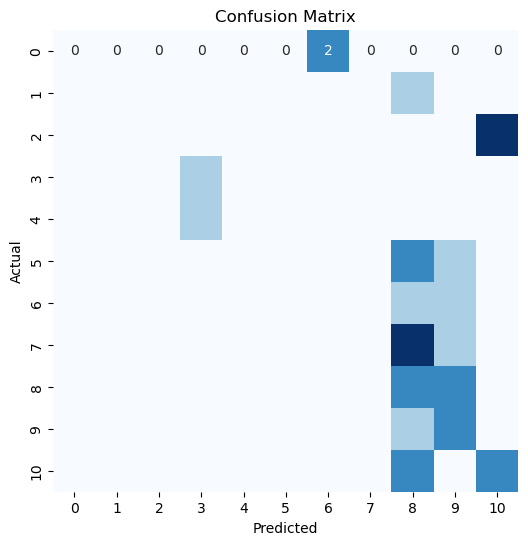

In [103]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
			)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()